####Loading the Data from Kaggle

In [1]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tobiasbueck/multilingual-customer-support-tickets")

print("Path to dataset files:", path)

100%|██████████| 16.1M/16.1M [00:00<00:00, 107MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tobiasbueck/multilingual-customer-support-tickets/versions/14


In [3]:
import os

path_to_dataset = "/root/.cache/kagglehub/datasets/tobiasbueck/multilingual-customer-support-tickets/versions/14"

os.listdir(path_to_dataset)

['dataset-tickets-german_normalized.csv',
 'dataset-tickets-german_normalized_50_5_2.csv',
 'aa_dataset-tickets-multi-lang-5-2-50-version.csv',
 'dataset-tickets-multi-lang-4-20k.csv',
 'dataset-tickets-multi-lang3-4k.csv']

In [6]:
BASE_DIR = "/root/.cache/kagglehub/datasets/tobiasbueck/multilingual-customer-support-tickets/versions/14/dataset-tickets-multi-lang-4-20k.csv"

df = pd.read_csv(BASE_DIR)

print("Dataset has ", df.shape[0], " rows and ", df.shape[1], " columns")
print("Columns", list(df.columns))

Dataset has  20000  rows and  15  columns
Columns ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']


####Analyzing the dataset

In [7]:
text_columns = []

if "subject" in df.columns and "body" in df.columns:
  text_columns = ["subject", "body"]
  print("Text columns: subject, body")
elif "subject" in df.columns:
  text_columns = ["subject"]
  print("Text columns: subject")
else:
  other_text = ["description", "text", "content"]

  for col in other_text:
    if col in df.columns:
     text_columns = [col]
     print("Text columns: ", text_columns)
     break


Text columns: subject, body


In [8]:
label_col = None
labels = ["queue", "tag_1", "label", "category", "department"]

for col in labels:
  if col in df.columns:
    label_col = col
    print("Label column: ", label_col)
    break

if label_col is None:
  print("No label column found")

Label column:  queue


####Creating model input

In [9]:
if "subject" in df.columns:
  df["subject"] = df["subject"].fillna("")

if "body" in df.columns:
  df["body"] = df["body"].fillna("")

In [11]:
if "subject" in df.columns and "body" in df.columns:
  df["Final_Text"] = df["subject"] + " " + df["body"]
else:
  df["Final_Text"] = df[text_columns[0]]

In [12]:
df["Final_Text"] = df["Final_Text"].str.strip()

print("Sample Final text: ", df["Final_Text"][0])

Sample Final text:  Unvorhergesehener Absturz der Datenanalyse-Plattform Die Datenanalyse-Plattform brach unerwartet ab, da die Speicheroberfläche zu gering war. Ich habe versucht, Laravel 8 und meinen MacBook Pro neu zu starten, aber das Problem behält sich bei. Ich benötige Ihre Unterstützung, um diesen Fehler zu beheben.


####Defining model output

In [18]:
queue_counts = df[label_col].value_counts()
print("unique queues:", len(queue_counts))

unique queues: 10


In [19]:
print(queue_counts.head(10))

queue
Technical Support                  5824
Product Support                    3708
Customer Service                   3152
IT Support                         2292
Billing and Payments               2086
Returns and Exchanges              1001
Service Outages and Maintenance     764
Sales and Pre-Sales                 572
Human Resources                     338
General Inquiry                     263
Name: count, dtype: int64


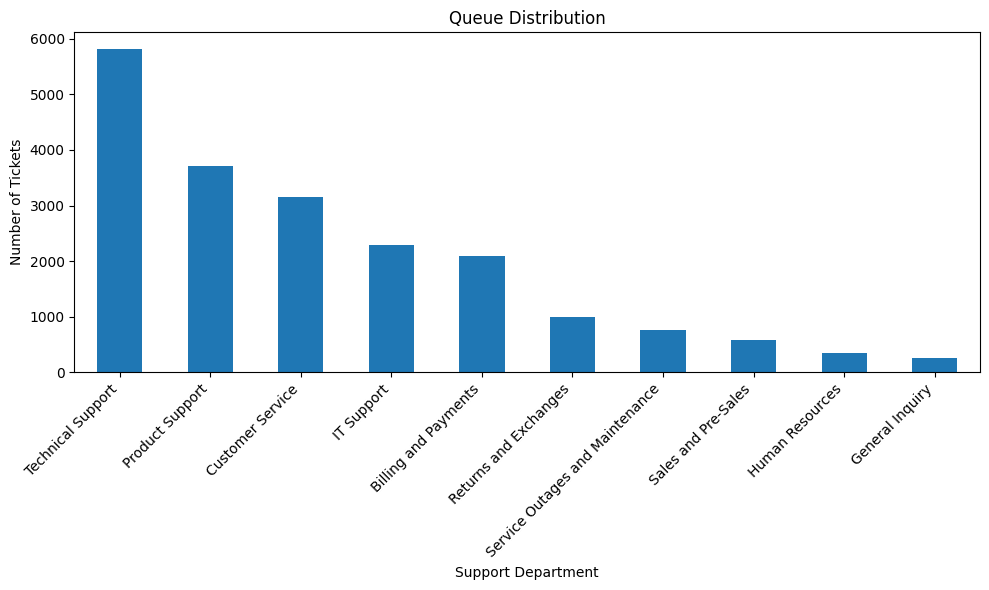

In [21]:
plt.figure(figsize=(10, 6))
if len(queue_counts) > 15:
    top_15 = queue_counts.head(15)
    top_15.plot(kind='bar')
    plt.title('Top 15 Queue Distribution')
else:
    queue_counts.plot(kind='bar')
    plt.title('Queue Distribution')

plt.xlabel('Support Department')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('queue_distribution.png', dpi=100)
plt.show()

####Dataset inspection

In [22]:
missing_subjects = df["subject"].isna().sum()
missing_body = df["body"].isna().sum()
missing_queue = df[label_col].isna().sum()

print("Missing subjects:", missing_subjects)
print("Missing body:", missing_body)
print("Missing queue:", missing_queue)

Missing subjects: 0
Missing body: 0
Missing queue: 0


In [26]:
df["text_length"] = df["Final_Text"].apply(len)

print("Average characters: ", df["text_length"].mean())
print("Max characters: ", df["text_length"].max())
print("Min characters: ", df["text_length"].min())

Average characters:  436.95815
Max characters:  2284
Min characters:  4


In [28]:
sample = df.sample(3, random_state=42)

for idx, row in sample.iterrows():
  prew = row["Final_Text"][:150] + "..." if len(row["Final_Text"]) > 150 else row["Final_Text"]
  print("\n Queue: ", row[label_col])
  print("Text: ", prew)


 Queue:  Technical Support
Text:  Alarm für Datenverstoß Es gab einen medizinischen Datenverlust aufgrund mangelnder Verschlüsselung und veralteter Apache Hadoop. Es wurde unerlaubter ...

 Queue:  IT Support
Text:  Failure in Medical Data Encryption I'm encountering difficulties with the medical data encryption process. It suddenly stopped working, and I believe ...

 Queue:  Technical Support
Text:  Optimierung der Datenverarbeitung Ich möchte eine Erweiterungsvorschlag für die Datenverarbeitung und Investitionsoptimierung einreichen. Bitte stelle...


####Cleaning the Dataset

In [29]:
initial_count = len(df)
print("Initial count: ", initial_count)

if "subject" in df.columns and "body" in df.columns:
  mask = (df["subject"].isna()) & (df["body"].isna())
  df = df[~mask]

  print("Dropped count: ", mask.sum())

Initial count:  20000
Dropped count:  0


In [30]:
mask = df[label_col].isna()
df = df[~mask]

print("Dropped count: ", mask.sum())

Dropped count:  0


In [31]:
mask = (df["Final_Text"].str.strip() == "")
df = df[~mask]

print("Dropped count: ", mask.sum())

Dropped count:  0


In [32]:
print(f"  Final dataset: {len(df)} rows ({initial_count - len(df)} removed)")

  Final dataset: 20000 rows (0 removed)


In [33]:
df.to_csv("cleaned_dataset.csv", index=False)
print("Saved the cleaned dataset")

Saved the cleaned dataset


####Text Preprocessing

In [34]:
import re
import json
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
os.makedirs("data", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

In [36]:
df = pd.read_csv("/content/cleaned_dataset.csv")

print("Ticket Count:", len(df))

Ticket Count: 20000


In [37]:
print("Sample: ", df["Final_Text"][0])

Sample:  Unvorhergesehener Absturz der Datenanalyse-Plattform Die Datenanalyse-Plattform brach unerwartet ab, da die Speicheroberfläche zu gering war. Ich habe versucht, Laravel 8 und meinen MacBook Pro neu zu starten, aber das Problem behält sich bei. Ich benötige Ihre Unterstützung, um diesen Fehler zu beheben.


In [39]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[label_col])

print("Train set: ", len(train_df))
print("Test set: ", len(temp_df))

Train set:  14000
Test set:  6000


In [40]:
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[label_col])

print("Validation set: ", len(val_df))
print("Test set: ", len(test_df))

Validation set:  3000
Test set:  3000


In [41]:
def preprocessing(text):

  if not isinstance(text, str):
    return ""

  text = text.lower()
  text = re.sub(r"\s+", " ", text)

  return text.strip()

In [43]:
train_texts = train_df["Final_Text"].tolist()
processed_texts = [preprocessing(text) for text in train_texts]

print("Processed Sample: ", processed_texts[0])

Processed Sample:  digital campaign metrics vanished unexpectedly today dear support team, i am reaching out to report an issue with the digital campaign metrics which have vanished without any clear reason. i suspect a problem with the api integration. restarting the analytics tool and reviewing the data connectors did not resolve the issue. i would greatly appreciate your assistance in investigating this problem and offering a resolution as soon as possible. the missing metrics are essential for our marketing team to assess the effectiveness of our campaigns. please advise if you require any additional information from me to address this issue. i have reviewed the tool settings, and they appear to be correct. i am eager to hear from you soon. thank you for your help. sincerely, [your name]


In [44]:
max_vocab_size = 2000

In [46]:
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")

tokenizer.fit_on_texts(processed_texts)

In [47]:
vocab_size = min(max_vocab_size, len(tokenizer.word_index) + 1)

print("Vocab size: ", vocab_size)
print("Common Words: ", list(tokenizer.word_index.items())[:5])

Vocab size:  2000
Common Words:  [('<OOV>', 1), ('the', 2), ('to', 3), ('and', 4), ('i', 5)]
